In [1]:
#set environment variables after creating environment from the yaml file provided
!setup.bat


(ryzenai-1) E:\experiments\ryzenai_chatbot\Chatbot-with-RyzenAI-1.0>SET PWD=E:\experiments\ryzenai_chatbot\Chatbot-with-RyzenAI-1.0\ 

(ryzenai-1) E:\experiments\ryzenai_chatbot\Chatbot-with-RyzenAI-1.0>SET THIRD_PARTY=E:\experiments\ryzenai_chatbot\Chatbot-with-RyzenAI-1.0\\third_party 

(ryzenai-1) E:\experiments\ryzenai_chatbot\Chatbot-with-RyzenAI-1.0>SET TVM_LIBRARY_PATH=E:\experiments\ryzenai_chatbot\Chatbot-with-RyzenAI-1.0\\third_party\lib;E:\experiments\ryzenai_chatbot\Chatbot-with-RyzenAI-1.0\\third_party\bin 

(ryzenai-1) E:\experiments\ryzenai_chatbot\Chatbot-with-RyzenAI-1.0>SET PATH=C:\Users\MicroZaib\miniconda3\envs\ryzenai-1;C:\Users\MicroZaib\miniconda3\envs\ryzenai-1\Library\mingw-w64\bin;C:\Users\MicroZaib\miniconda3\envs\ryzenai-1\Library\usr\bin;C:\Users\MicroZaib\miniconda3\envs\ryzenai-1\Library\bin;C:\Users\MicroZaib\miniconda3\envs\ryzenai-1\Scripts;C:\Users\MicroZaib\miniconda3\envs\ryzenai-1\bin;C:\Users\MicroZaib\miniconda3\condabin;C:\Windows\system32;C:\W

In [2]:
#Add required system paths
import sys
sys.path.append("../ext") 
sys.path.append("../smoothquant_package") 
sys.path.append("./gradio_app") 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import logging
import time
import gc
import os
from optimum.onnxruntime import ORTModelForCausalLM
from transformers import set_seed, AutoTokenizer, AutoTokenizer, OPTForCausalLM, AutoModelForCausalLM
import pathlib
# import smooth
import torch
import random 
import string
import gradio as gr
import time
# from modeling_ort_amd import ORTModelForCausalLM
from smoothquant_package.smooth import smooth_lm


In [16]:
# function to define model path where downloaded pretrained model would be saved
model_id = "microsoft/Florence-2-base" #path to pretrained model on huggingface hub
def model_path_fp32(model_id):
    model_name = model_id.rsplit('/')[-1]
    out_dir = "./%s_pretrained_fp32"%model_name
    model_path_fp32 = out_dir  
    return model_path_fp32

model_path_fp32(model_id)

'./Florence-2-base_pretrained_fp32'

In [17]:
# download and save model from huggingface model hub
def download_model(model_id):
    """ Downloads and saves a pretratined model from (e.g. HF) to the specified dir
    Args: 
    model_path_pt - pretrained model path (e.g. facebook/opt-1.3b) 
    Output: fp-32 model saved in specified dir """
    
    model_name = model_id.rsplit('/')[-1] #extract model name from model path pretrained using python string methods
    model = AutoModelForCausalLM.from_pretrained(model_id)
#specify a dir for saving the model
    out_dir = "./%s_pretrained_fp32"%model_name
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    model.save_pretrained(out_dir)
    # print(out_dir)

download_model(model_id)



config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

C:\Users\MicroZaib\miniconda3\envs\ryzenai-transformers\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MicroZaib\.cache\huggingface\hub\models--microsoft--Florence-2-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ValueError: The repository for microsoft/Florence-2-base contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/microsoft/Florence-2-base.
Please pass the argument `trust_remote_code=True` to allow custom code to be run.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
!pip install llama-cpp-python

     ---------------------------------------- 0.0/50.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/50.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/50.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/50.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/50.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/50.2 MB ? eta -:--:--
     --------------------------------------- 0.0/50.2 MB 330.3 kB/s eta 0:02:32
     --------------------------------------- 0.0/50.2 MB 245.8 kB/s eta 0:03:24
     --------------------------------------- 0.0/50.2 MB 245.8 kB/s eta 0:03:24
     --------------------------------------- 0.1/50.2 MB 234.9 kB/s eta 0:03:34
     --------------------------------------- 0.1/50.2 MB 270.5 kB/s eta 0:03:06
     --------------------------------------- 0.1/50.2 MB 262.6 kB/s eta 0:03:11
     --------------------------------------- 0.1/50.2 MB 300.4 kB/s eta 0:02:47
     ---

In [8]:
from llama_cpp import Llama

In [18]:
# Qwen2-0.5B-Instruct-GGUF
model_path = "./Qwen2-0.5B-Instruct-GGUF/qwen2-0_5b-instruct-q8_0.gguf"
from llama_cpp import Llama
llm = Llama(model_path=model_path, streaming=True)

llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from ./Qwen2-0.5B-Instruct-GGUF/qwen2-0_5b-instruct-q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.name str              = qwen2-0_5b
llama_model_loader: - kv   2:                          qwen2.block_count u32              = 24
llama_model_loader: - kv   3:                       qwen2.context_length u32              = 32768
llama_model_loader: - kv   4:                     qwen2.embedding_length u32              = 896
llama_model_loader: - kv   5:                  qwen2.feed_forward_length u32              = 4864
llama_model_loader: - kv   6:                 qwen2.attention.head_count u32              = 14
llama_model_loader: - kv   7:              qwen2.atten

In [19]:
response = llm("Python code to plot the function y=x**3-x**2-x for x between -2 and 3", max_tokens=1000)
response


llama_print_timings:        load time =     116.31 ms
llama_print_timings:      sample time =      57.67 ms /   137 runs   (    0.42 ms per token,  2375.67 tokens per second)
llama_print_timings: prompt eval time =     116.24 ms /    23 tokens (    5.05 ms per token,   197.86 tokens per second)
llama_print_timings:        eval time =    1512.95 ms /   136 runs   (   11.12 ms per token,    89.89 tokens per second)
llama_print_timings:       total time =    1835.44 ms /   159 tokens


{'id': 'cmpl-1545800b-5787-4eaf-b76f-c7da36ff1f2f',
 'object': 'text_completion',
 'created': 1718571228,
 'model': './Qwen2-0.5B-Instruct-GGUF/qwen2-0_5b-instruct-q8_0.gguf',
 'choices': [{'text': '.\n\n```python\nimport numpy as np\n\nx = np.linspace(-2, 3, 40)\ny = x ** 3 - x ** 2 - x\n\nplt.plot(x, y)\n```\n\nThis code uses the `numpy` library to generate a 40-element array of values from -2 to 3 for the independent variable `x`. It then computes the function `f(x) = x^3 - x^2 - x` for this set of data and plots it with the `plot()` method. The resulting plot should look like this:\n\n![Function Plot](https://i.imgur.com/9yD8n.jpg)',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 23, 'completion_tokens': 136, 'total_tokens': 159}}

In [21]:
# stable_code_instruct-3B-GGUF
model_path = "./stable-code-instruct-3B-GGUF/stable-code-instruct-3b.Q8_0.gguf"
from llama_cpp import Llama
llm = Llama(model_path=model_path, streaming=True)

llama_model_loader: loaded meta data with 21 key-value pairs and 356 tensors from ./stable-code-instruct-3B-GGUF/stable-code-instruct-3b.Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = stablelm
llama_model_loader: - kv   1:                               general.name str              = stable-code-instruct-3b
llama_model_loader: - kv   2:                    stablelm.context_length u32              = 16384
llama_model_loader: - kv   3:                  stablelm.embedding_length u32              = 2560
llama_model_loader: - kv   4:                       stablelm.block_count u32              = 32
llama_model_loader: - kv   5:               stablelm.feed_forward_length u32              = 6912
llama_model_loader: - kv   6:              stablelm.rope.dimension_count u32              = 20
llama_model_loader: - kv   7:

In [22]:
response = llm("Python code to plot the function y=x**3-x**2-x for x between -2 and 3", max_tokens=1000)
response


llama_print_timings:        load time =     401.43 ms
llama_print_timings:      sample time =      22.31 ms /   152 runs   (    0.15 ms per token,  6812.78 tokens per second)
llama_print_timings: prompt eval time =     401.35 ms /    27 tokens (   14.86 ms per token,    67.27 tokens per second)
llama_print_timings:        eval time =    7892.81 ms /   151 runs   (   52.27 ms per token,    19.13 tokens per second)
llama_print_timings:       total time =    8397.07 ms /   178 tokens


{'id': 'cmpl-e3a44464-4cbd-4c88-be4b-de6b43551f76',
 'object': 'text_completion',
 'created': 1718577908,
 'model': './stable-code-instruct-3B-GGUF/stable-code-instruct-3b.Q8_0.gguf',
 'choices': [{'text': ".0:\n\n```python\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Define the function\ndef f(x):\n    return (x ** 3) - (x ** 2)) - x\n\n# Create an array of x values between -2 and 3.0\nx = np.linspace(-2, 3.0), 100)\n\n# Evaluate the function at each x value\ny = f(x)\n\n# Plot the function\nplt.plot(x, y)\nplt.title('Function y = x^3 - x^2 - x')\nplt.grid(True)\nplt.show()\n```<|im_end|>\n",
   'index': 0,
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 27, 'completion_tokens': 151, 'total_tokens': 178}}

In [23]:
response = llm("Python code to generate fibonnaci sequence, print first 15 numbers", max_tokens=1000)
response

Llama.generate: prefix-match hit

llama_print_timings:        load time =     401.43 ms
llama_print_timings:      sample time =      23.90 ms /   172 runs   (    0.14 ms per token,  7196.65 tokens per second)
llama_print_timings: prompt eval time =     249.85 ms /    12 tokens (   20.82 ms per token,    48.03 tokens per second)
llama_print_timings:        eval time =    8872.78 ms /   171 runs   (   51.89 ms per token,    19.27 tokens per second)
llama_print_timings:       total time =    9227.73 ms /   183 tokens


{'id': 'cmpl-b92a29fb-2893-47b9-829c-a3342634a901',
 'object': 'text_completion',
 'created': 1718577989,
 'model': './stable-code-instruct-3B-GGUF/stable-code-instruct-3b.Q8_0.gguf',
 'choices': [{'text': ':\n\n```python\ndef fibonacci(n):\n    if n <= 0:\n        return []\n    elif n == 1:\n        return [0]\n    else:\n        fib = [0, 1]\n        for i in range(2, n):\n            fib.append(fib[i-1] + fib[i-2]))\n        return fib\n\n\nprint(fibonacci(15)))\n```\n\nThis code defines a function `fibonacci` that takes an integer `n` as input and returns the first `n` numbers in the Fibonacci sequence. The code then calls this function with `n=15` to print the first 15 numbers in the Fibonacci sequence, and uses the `print` function to display these numbers.<|im_end|>\n',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 16, 'completion_tokens': 171, 'total_tokens': 187}}

In [24]:
# gemma-2b-it-GGUF
model_path = "./gemma-2b-it-GGUF/gemma-2b-it-q8_0.gguf"
from llama_cpp import Llama
llm = Llama(model_path=model_path, streaming=True)

llama_model_loader: loaded meta data with 21 key-value pairs and 164 tensors from ./gemma-2b-it-GGUF/gemma-2b-it-q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma
llama_model_loader: - kv   1:                               general.name str              = gemma-2b-it
llama_model_loader: - kv   2:                       gemma.context_length u32              = 8192
llama_model_loader: - kv   3:                          gemma.block_count u32              = 18
llama_model_loader: - kv   4:                     gemma.embedding_length u32              = 2048
llama_model_loader: - kv   5:                  gemma.feed_forward_length u32              = 16384
llama_model_loader: - kv   6:                 gemma.attention.head_count u32              = 8
llama_model_loader: - kv   7:              gemma.attention.head_count

In [25]:
response = llm("Python code to plot the function y=x**3-x**2-x for x between -2 and 3", max_tokens=1000)
response


llama_print_timings:        load time =     386.52 ms
llama_print_timings:      sample time =      73.37 ms /   109 runs   (    0.67 ms per token,  1485.56 tokens per second)
llama_print_timings: prompt eval time =     386.48 ms /    26 tokens (   14.86 ms per token,    67.27 tokens per second)
llama_print_timings:        eval time =    5134.02 ms /   108 runs   (   47.54 ms per token,    21.04 tokens per second)
llama_print_timings:       total time =    5754.03 ms /   134 tokens


{'id': 'cmpl-206da09f-42ad-4435-92dc-f1a60d55aef8',
 'object': 'text_completion',
 'created': 1718578383,
 'model': './gemma-2b-it-GGUF/gemma-2b-it-q8_0.gguf',
 'choices': [{'text': '\n\n```python\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Define the function\ndef f(x):\n  return x ** 3 - x ** 2 - x\n\n# Create a numpy array of x values\nx = np.linspace(-2, 3, 100)\n\n# Evaluate the function for each x value\ny = f(x)\n\n# Plot the function\nplt.plot(x, y)\n\n# Show the plot\nplt.show()\n```',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 26, 'completion_tokens': 108, 'total_tokens': 134}}

In [26]:
response = llm("What is an LLM?", max_tokens=1000)
response

Llama.generate: prefix-match hit

llama_print_timings:        load time =     386.52 ms
llama_print_timings:      sample time =      74.77 ms /   111 runs   (    0.67 ms per token,  1484.63 tokens per second)
llama_print_timings: prompt eval time =     195.53 ms /     6 tokens (   32.59 ms per token,    30.69 tokens per second)
llama_print_timings:        eval time =    5153.04 ms /   110 runs   (   46.85 ms per token,    21.35 tokens per second)
llama_print_timings:       total time =    5588.54 ms /   116 tokens


{'id': 'cmpl-796e9e23-d9ce-44b5-8f0c-612d82ab1dde',
 'object': 'text_completion',
 'created': 1718578452,
 'model': './gemma-2b-it-GGUF/gemma-2b-it-q8_0.gguf',
 'choices': [{'text': '\n\nAn Large Language Model (LLM) is a powerful artificial intelligence model that has surpassed human capabilities in language understanding and generation. LLMs are trained on massive datasets of text and code, allowing them to perform a wide range of natural language processing (NLP) tasks, including:\n\n- Text generation\n- Language translation\n- Question answering\n- Summarization\n- Sentiment analysis\n\nLLMs are typically used in research and development, education, and commercial applications. Some well-known LLMs include GPT-3, BERT, and T5.',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 7, 'completion_tokens': 110, 'total_tokens': 117}}

In [35]:
def generate_gguf_response(prompt, max_tokens, model_path = "./Qwen2-0.5B-Instruct-GGUF/qwen2-0_5b-instruct-q8_0.gguf" ):
    from llama_cpp import Llama
    llm = Llama(model_path=model_path, streaming=True)
    response = llm(prompt, max_tokens=max_tokens)
    print(response)
    yield response
    

llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from ./Qwen2-0.5B-Instruct-GGUF/qwen2-0_5b-instruct-q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.name str              = qwen2-0_5b
llama_model_loader: - kv   2:                          qwen2.block_count u32              = 24
llama_model_loader: - kv   3:                       qwen2.context_length u32              = 32768
llama_model_loader: - kv   4:                     qwen2.embedding_length u32              = 896
llama_model_loader: - kv   5:                  qwen2.feed_forward_length u32              = 4864
llama_model_loader: - kv   6:                 qwen2.attention.head_count u32              = 14
llama_model_loader: - kv   7:              qwen2.atten

{'id': 'cmpl-bae5d146-effc-488c-a223-bafd3021a995', 'object': 'text_completion', 'created': 1718580791, 'model': './Qwen2-0.5B-Instruct-GGUF/qwen2-0_5b-instruct-q8_0.gguf', 'choices': [{'text': ' The Law School Admission Test (LSAT) is a standardized test that assesses the ability of applicants to learn, understand and apply the law. The LSAT', 'index': 0, 'logprobs': None, 'finish_reason': 'length'}], 'usage': {'prompt_tokens': 7, 'completion_tokens': 32, 'total_tokens': 39}}


In [36]:
gr.Interface(
    fn=generate_gguf_response,
    inputs=["text", gr.Slider(minimum=32, maximum=1024, value=32, step = 32)],
    outputs=["text"],
    title="Qwen-2 Chatbot on Ryzen AI GGUF",
    description="Qwen-2-0.5B-gguf Chatbot on Ryzen AI Laptop",
    concurrency_limit=4
    #).queue(concurrency_count=2).launch(server_name="localhost", server_port=1234)
    ).queue().launch(server_name="localhost", server_port=1238)

Running on local URL:  http://localhost:1238

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.8.0, however version 4.29.0 is available, please upgrade.
--------


llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from ./Qwen2-0.5B-Instruct-GGUF/qwen2-0_5b-instruct-q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.name str              = qwen2-0_5b
llama_model_loader: - kv   2:                          qwen2.block_count u32              = 24
llama_model_loader: - kv   3:                       qwen2.context_length u32              = 32768
llama_model_loader: - kv   4:                     qwen2.embedding_length u32              = 896
llama_model_loader: - kv   5:                  qwen2.feed_forward_length u32              = 4864
llama_model_loader: - kv   6:                 qwen2.attention.head_count u32              = 14
llama_model_loader: - kv   7:              qwen2.atten

{'id': 'cmpl-fe3612d0-3d2a-46df-b35e-f4a6493b2a6e', 'object': 'text_completion', 'created': 1718580816, 'model': './Qwen2-0.5B-Instruct-GGUF/qwen2-0_5b-instruct-q8_0.gguf', 'choices': [{'text': ', using a custom plotting library that supports multiple output formats.\n\nNote: This problem requires understanding of the mathematical concept of exponentiation (base raised to an exponent)', 'index': 0, 'logprobs': None, 'finish_reason': 'length'}], 'usage': {'prompt_tokens': 23, 'completion_tokens': 32, 'total_tokens': 55}}


llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from ./Qwen2-0.5B-Instruct-GGUF/qwen2-0_5b-instruct-q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.name str              = qwen2-0_5b
llama_model_loader: - kv   2:                          qwen2.block_count u32              = 24
llama_model_loader: - kv   3:                       qwen2.context_length u32              = 32768
llama_model_loader: - kv   4:                     qwen2.embedding_length u32              = 896
llama_model_loader: - kv   5:                  qwen2.feed_forward_length u32              = 4864
llama_model_loader: - kv   6:                 qwen2.attention.head_count u32              = 14
llama_model_loader: - kv   7:              qwen2.atten

{'id': 'cmpl-19c70e0c-eb87-4d9c-a978-d9866967197d', 'object': 'text_completion', 'created': 1718580833, 'model': './Qwen2-0.5B-Instruct-GGUF/qwen2-0_5b-instruct-q8_0.gguf', 'choices': [{'text': ".\n\nCertainly! Below is a Python code snippet that uses the `matplotlib` library to plot the function `y = x^3 - x^2 - x` from `-2` to `3`.\n\n```python\nimport matplotlib.pyplot as plt\n\n# Define the equation\ndef f(x):\n    return x**3 - x**2 - x\n\n# Plot the function in a graph\nplt.plot([-2, 3], [f(-2), f(3)], color='blue', linestyle='-')\nplt.title('Plot of y = x^3 - x^2 - x')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.grid(True)\nplt.show()\n```\n\n### Explanation:\n1. **Importing the necessary libraries**: The first line imports `matplotlib.pyplot` and `mathplotlib.pyplot` from `matplotlib` as part of a package, ensuring compatibility with Python 3.\n2. **Declaring the function**: Defines a function named `f(x)` that calculates the value of y = x^3 - x^2 - x for given x values in the rang

In [3]:
from llama_cpp import Llama
model_path = "./stable-code-instruct-3B-GGUF/stable-code-instruct-3b.Q8_0.gguf"
llm = Llama(
      model_path = model_path,
      # n_gpu_layers=-1, # Uncomment to use GPU acceleration
      # seed=1337, # Uncomment to set a specific seed
      # n_ctx=2048, # Uncomment to increase the context window
)
output = llm(
      "Q: Name the planets in the solar system? A: ", # Prompt
      max_tokens=32, # Generate up to 32 tokens, set to None to generate up to the end of the context window
      stop=["Q:", "\n"], # Stop generating just before the model would generate a new question
      echo=True # Echo the prompt back in the output
) # Generate a completion, can also call create_completion
print(output)

llama_model_loader: loaded meta data with 21 key-value pairs and 356 tensors from ./stable-code-instruct-3B-GGUF/stable-code-instruct-3b.Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = stablelm
llama_model_loader: - kv   1:                               general.name str              = stable-code-instruct-3b
llama_model_loader: - kv   2:                    stablelm.context_length u32              = 16384
llama_model_loader: - kv   3:                  stablelm.embedding_length u32              = 2560
llama_model_loader: - kv   4:                       stablelm.block_count u32              = 32
llama_model_loader: - kv   5:               stablelm.feed_forward_length u32              = 6912
llama_model_loader: - kv   6:              stablelm.rope.dimension_count u32              = 20
llama_model_loader: - kv   7:

{'id': 'cmpl-0e7c7a27-f451-4846-987a-163fd77fb7b7', 'object': 'text_completion', 'created': 1718723266, 'model': './stable-code-instruct-3B-GGUF/stable-code-instruct-3b.Q8_0.gguf', 'choices': [{'text': 'Q: Name the planets in the solar system? A: ', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 14, 'completion_tokens': 1, 'total_tokens': 15}}


In [3]:
from llama_cpp import Llama
llm = Llama(
      model_path="./stable-code-instruct-3B-GGUF/stable-code-instruct-3b.Q8_0.gguf",
      chat_format="llama-2"
)
llm.create_chat_completion(
      messages = [
          {"role": "system", "content": "You are an assistant who can write perfect Python code."},
          {
              "role": "user",
              "content": "Python code to plot the function y=x**3-x**2-x for x between -2 and 3."
          }
      ]
)

llama_model_loader: loaded meta data with 21 key-value pairs and 356 tensors from ./stable-code-instruct-3B-GGUF/stable-code-instruct-3b.Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = stablelm
llama_model_loader: - kv   1:                               general.name str              = stable-code-instruct-3b
llama_model_loader: - kv   2:                    stablelm.context_length u32              = 16384
llama_model_loader: - kv   3:                  stablelm.embedding_length u32              = 2560
llama_model_loader: - kv   4:                       stablelm.block_count u32              = 32
llama_model_loader: - kv   5:               stablelm.feed_forward_length u32              = 6912
llama_model_loader: - kv   6:              stablelm.rope.dimension_count u32              = 20
llama_model_loader: - kv   7:

{'id': 'chatcmpl-d4f7c737-1e6b-4134-acd3-ee3866e089b2',
 'object': 'chat.completion',
 'created': 1718796116,
 'model': './stable-code-instruct-3B-GGUF/stable-code-instruct-3b.Q8_0.gguf',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': "\nHere's the Python code using matplotlib library:\n```python\nimport numpy as np\nimport matplotlib.pyplot as plt\n# Define the function\ndef f(x):\n return x**3 - x**2 - x\n# Generate data for the plot\nx = np.linspace(-2, 3), 100)\ny = f(x)\n# Plot the graph\nplt.plot(x, y)\nplt.title('Plot of y=x^3-x^2-x')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.grid()\nplt.show()\n```\nThis code generates a plot of the function y = x^3 - x^2 - x for x between -2 and 3. The plot includes gridlines, a title, and labels for the x and y axes.<|im_end|>\n"},
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 56, 'completion_tokens': 191, 'total_tokens': 247}}

In [ ]:
def generate_response(prompt, max_output_tokens, model_id, device = "cpu"):
    
    model_path=model_path_fp32(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype="auto",
        device_map="auto"
    )
    model_name = model_id.rsplit('/')[-1] 
    model_path = model_path_fp32(model_id)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    messages = [
    {"role": "system", "content": "You are a helpful python coding assistant."},
    {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)
    
    s = time.perf_counter()
    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=max_output_tokens, use_cache=True, do_sample=False)
    e = time.perf_counter() - s
    outputs_tkn_len = generated_ids.shape[1]
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(response)
    yield response, "tkn/sec: " + str(outputs_tkn_len/e)
    
    

In [ ]:
gr.Interface(
    fn=generate_response,
    inputs=["text", gr.Slider(minimum=32, maximum=1024, value=32, step = 32), "text"],
    outputs=["text", "text"],
    title="Qwen-2 Chatbot on Ryzen AI without NPU",
    description="Qwen-2 fp-32 Chatbot on Ryzen AI Laptop",
    concurrency_limit=4
    #).queue(concurrency_count=2).launch(server_name="localhost", server_port=1234)
    ).queue().launch(server_name="localhost", server_port=1236)

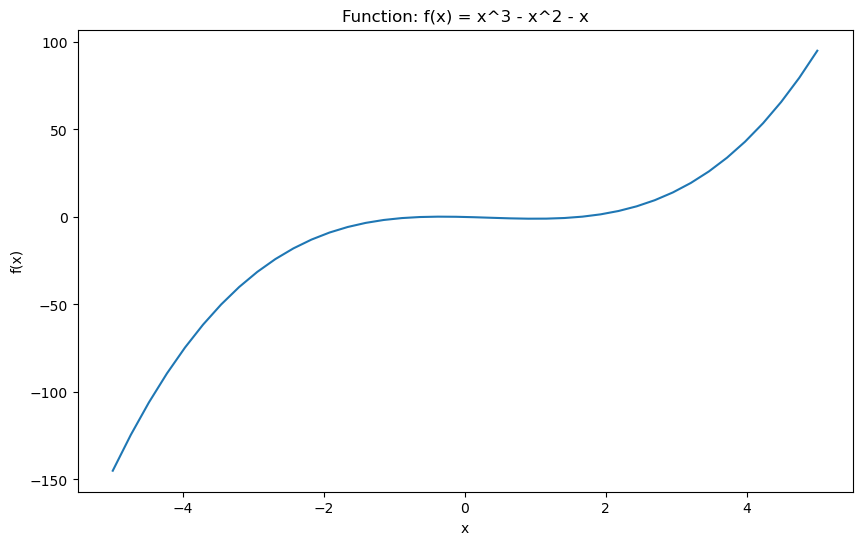

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Set up some sample data points to plot
x = np.linspace(-5, 5, 40)
y = x**3 - x**2 - x

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(x, y)

# Add labels and title
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function: f(x) = x^3 - x^2 - x')

# Show the plot
plt.show()

In [ ]:
print(os.system("optimum-cli export onnx --help"))

In [ ]:
import subprocess
result = subprocess.run(["optimum-cli", "export", "onnx", "--help"], capture_output=True)
print(result.stdout.decode())  # Print the captured output


- Create activation channel scales for the downloaded modelfor smooth quantization
- To be incorporated later from https://github.com/mit-han-lab/smoothquant
- Using downloaded act_scales in this example

In [ ]:
#quantize the downloaded fp32 model to int8 quantized model after first smooth-quantizing
def model_quant(model_path_fp32, model_id):
    """ Quantizes and saves the downloaded fp32 pretratined model to the specified dir, first as smooth quant and then as int8 quantized model
    Args: 
    model_path_fp32 - downloaded fp32 model path  
    model_path_pt - pretrained model path (e.g. facebook/opt-1.3b)
    Output: smooth quant model saved in specified dir """
    
    path = model_path_fp32(model_id)
    model_name = model_id.rsplit('/')[-1]
    if not os.path.exists(path):
            print(f"Pretrained fp32 model not found, exiting..")
            exit(1)
    model = OPTForCausalLM.from_pretrained(path)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model.tokenizer = tokenizer 
     # get actuvation scales for smooth quantization
    model_act = "%s.pt"%model_name
    act_scales = torch.load("./ext/smoothquant/act_scales/" + model_act)
    # smooth quantize
    smooth_lm(model, act_scales, 0.5)
    print(model)
    # initialize with random prompt
    prompt = ''.join(random.choices(string.ascii_lowercase + " ", k=model.config.max_position_embeddings))
    #inputs = tokenizer(prompt, return_tensors="pt")  # takes a lot of time
    inputs = tokenizer("What is meaning of life", return_tensors="pt") 
    print(f"inputs: {inputs}")
    print(f"inputs.input_ids: {inputs.input_ids}")
    for key in inputs.keys():
        print(inputs[key].shape)
        print(inputs[key])
    model_out = model(inputs.input_ids)
    print(f"{(model_out.logits.shape)=}")
    out_dir = "./%s_smoothquant"%model_name
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    model.save_pretrained(out_dir+"/model_onnx")
    print(f"Saving Smooth Quant fp32 model...\n ")

    print(f"Quantizing model with Optimum...\n ")
    #proc = subprocess.Popen('cmd.exe', stdin = subprocess.PIPE, stdout = subprocess.PIPE)
    os.system('optimum-cli export onnx -m out_dir\model_onnx --task text-generation-with-past out_dir\model_onnx_int8  --framework pt --no-post-process')
    print(f"Saving quantized int8 model ...\n ")  


In [ ]:
model_quant(model_path_fp32, model_id)

In [ ]:
path = model_path_fp32(model_id)
if not os.path.exists(path):
    print(f"Pretrained fp32 model not found, exiting..")
    exit(1)
model = OPTForCausalLM.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained(model_path_pt)
model.tokenizer = tokenizer

In [ ]:
model_name = model_id.rsplit('/')[-1]
model_act = "%s.pt"%model_name
act_scales = torch.load("./ext/smoothquant/act_scales/" + model_act)
# act_scales = torch.load(os.getenv("PYTORCH_AIE_PATH") + "/ext/smoothquant/act_scales/" + "opt-1.3b.pt")

In [ ]:
smooth_lm(model, act_scales, 0.5)
print(model)

In [ ]:
prompt = ''.join(random.choices(string.ascii_lowercase + " ", k=model.config.max_position_embeddings))
#inputs = tokenizer(prompt, return_tensors="pt")  # takes a lot of time
inputs = tokenizer("What is meaning of life", return_tensors="pt") 
print(f"inputs: {inputs}")
print(f"inputs.input_ids: {inputs.input_ids}")    

In [ ]:
for key in inputs.keys():
    print(inputs[key].shape)
    print(inputs[key])
model_out = model(inputs.input_ids)
print(f"{(model_out.logits.shape)=}")
out_dir = "./%s_smoothquant"%model_name
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
model.save_pretrained(out_dir+"/model_onnx")
print(f"Saving Smooth Quant fp32 model...\n ")

In [ ]:
print(f"Quantizing model with Optimum...\n ")
#proc = subprocess.Popen('cmd.exe', stdin = subprocess.PIPE, stdout = subprocess.PIPE)
os.system('optimum-cli export onnx -m out_dir\model_onnx --task text-generation-with-past out_dir\model_onnx_int8  --framework pt --no-post-process')
print(f"Saving quantized int8 model ...\n ") 

In [ ]:
#Define path to vaip_config.json file needed to run Vitis AI Execution Provider and quantized model
model_id = "Qwen/Qwen2-0.5B-Instruct" #path to pretrained model on huggingface hub
model_name = model_id.rsplit('/')[-1]
out_dir = "./Qwen2-0.5B-Instruct-GGUF"
config_file_path = "./vaip_config.json"
model_path = out_dir

In [ ]:
providers = ["VitisAIExecutionProvider", "CPUExecutionProvider"]
provider_options = [{'config_file': str(config_file_path)}, {}]

In [ ]:
from transformers import AutoModelForCausalLM

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
device = "cuda" # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-0.5B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
# tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")


In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_path)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")

In [ ]:
prompt = "Who is Scarlett O'hara"

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt") 

In [ ]:
generate_ids = model.generate(inputs.input_ids, max_length=100)

In [ ]:
response = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

In [ ]:
print(response)

In [ ]:
config_file_path = "./vaip_config.json"
providers = ["VitisAIExecutionProvider", "CPUExecutionProvider"]
provider_options = [{'config_file': str(config_file_path)}, {}]

In [ ]:
def generate_text(Input_text, max_output_token, model_id = "facebook/opt-1.3b", p_type = 0, p_options = 0):
    model_name = model_id.rsplit('/')[-1]
    out_dir = "./%s_smoothquant"%model_name    
    onnx_model_path = out_dir+"/model_onnx_int8"
    model = ORTModelForCausalLM.from_pretrained(onnx_model_path, provider = providers[p_type], provider_options = provider_options[p_options])
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    inputs = tokenizer(Input_text, return_tensors="pt") 
    s = time.perf_counter()
    outputs_tkn = model.generate(inputs.input_ids, max_length=max_output_token, use_cache=True, do_sample=False)
    e = time.perf_counter() - s
    outputs_tkn_len = outputs_tkn.shape[1]
    outputs = tokenizer.batch_decode(outputs_tkn,
                                    skip_special_tokens=True, 
                                    clean_up_tokenization_spaces=False)[0]
    print(outputs)
    yield outputs, "tkn/sec: " + str(outputs_tkn_len/e)

In [ ]:
# def generate_text(Input_text, max_output_token):
#     inputs = tokenizer(Input_text, return_tensors="pt") 
#     s = time.perf_counter()
#     outputs_tkn = model.generate(inputs.input_ids, max_length=max_output_token, use_cache=True, do_sample=False)
#     e = time.perf_counter() - s
#     outputs_tkn_len = outputs_tkn.shape[1]
#     outputs = tokenizer.batch_decode(outputs_tkn,
#                                     skip_special_tokens=True, 
#                                     clean_up_tokenization_spaces=False)[0]
#     print(outputs)
#     yield outputs, "tkn/sec: " + str(outputs_tkn_len/e)

In [ ]:
gr.Interface(
    fn=generate_text,
    inputs=["text", gr.Slider(minimum=32, maximum=256, value=32, step = 32)],
    outputs=["text", "text"],
    title="OPT Chatbot on Ryzen AI",
    description="Simple Chatbot on Ryzen AI Laptop",
    concurrency_limit=4
    #).queue(concurrency_count=2).launch(server_name="localhost", server_port=1234)
    ).queue().launch(server_name="localhost", server_port=1234)

In [26]:
from llama_cpp import Llama
model_path = "./gemma-2b-it-GGUF/gemma-2b-it-q8_0.gguf"
client = Llama(model_path=model_path)
completion = client.create_chat_completion(
    messages = [
      {"role": "system", "content": "You are a helpful assistant who provides perfect answers."},
      {
          "role": "user",
          "content": "Where is India?"
      }
    ],
    temperature = 0.7,
    stream = True
    )

for chunk in completion:
     
    if chunk['choices'][0]['delta']['content']:
        print(chunk['choices'][0]['delta']['content'], end="", flush=True)
        new_message["content"] += chunk['choices'][0]['delta']['content']


llama_model_loader: loaded meta data with 21 key-value pairs and 164 tensors from ./gemma-2b-it-GGUF/gemma-2b-it-q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma
llama_model_loader: - kv   1:                               general.name str              = gemma-2b-it
llama_model_loader: - kv   2:                       gemma.context_length u32              = 8192
llama_model_loader: - kv   3:                          gemma.block_count u32              = 18
llama_model_loader: - kv   4:                     gemma.embedding_length u32              = 2048
llama_model_loader: - kv   5:                  gemma.feed_forward_length u32              = 16384
llama_model_loader: - kv   6:                 gemma.attention.head_count u32              = 8
llama_model_loader: - kv   7:              gemma.attention.head_count

KeyError: 'content'

In [7]:
print(completion['choices'][0]['message']['content'])

TypeError: 'generator' object is not subscriptable

In [9]:
from llama_cpp import Llama

model_path = "./gemma-2b-it-GGUF/gemma-2b-it-q8_0.gguf"
client = Llama(model_path=model_path)
completion = client.create_chat_completion(
    messages=[
        {"role": "system", "content": "You are a helpful assistant who provides perfect answers."},
        {"role": "user", "content": "Python code to plot a parabola?"}
    ],
    temperature=0.7,
    stream=True
)

# Initialize an empty string to store the assistant's response
assistant_response = ""

for chunk in completion:
    if "content" in chunk['choices'][0]['delta']:
        assistant_response += chunk['choices'][0]['delta']['content']

print(assistant_response)

llama_model_loader: loaded meta data with 21 key-value pairs and 164 tensors from ./gemma-2b-it-GGUF/gemma-2b-it-q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma
llama_model_loader: - kv   1:                               general.name str              = gemma-2b-it
llama_model_loader: - kv   2:                       gemma.context_length u32              = 8192
llama_model_loader: - kv   3:                          gemma.block_count u32              = 18
llama_model_loader: - kv   4:                     gemma.embedding_length u32              = 2048
llama_model_loader: - kv   5:                  gemma.feed_forward_length u32              = 16384
llama_model_loader: - kv   6:                 gemma.attention.head_count u32              = 8
llama_model_loader: - kv   7:              gemma.attention.head_count



```python
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 100)
y = x**2

plt.plot(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Parabola')
plt.show()
```


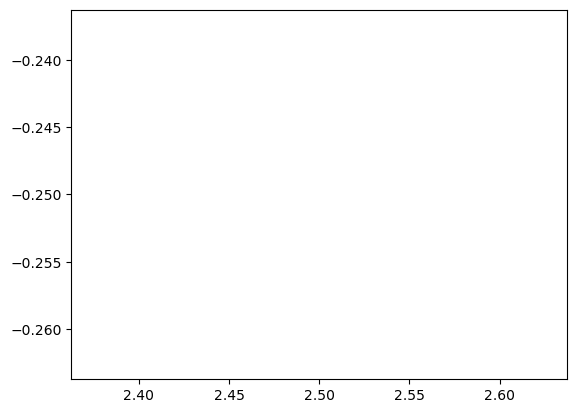

In [28]:
import matplotlib.pyplot as plt

# define the coefficients of the quadratic equation
a = 1
b = -5
c = 6

# calculate the x and y coordinates of the vertex of the parabola
x_vertex = -b/(2*a)
y_vertex = a*x_vertex**2 + b*x_vertex + c

# plot the parabola
plt.plot(x_vertex, y_vertex)

# show the plot
plt.show()

In [1]:
from llama_cpp import Llama

In [3]:
llm = Llama.from_pretrained(
    repo_id="NousResearch/Hermes-2-Pro-Llama-3-8B-GGUF",
    filename="*Hermes-2-Pro-Llama-3-8B-Q4_K_M.gguf",
    verbose=False
)

Hermes-2-Pro-Llama-3-8B-Q4_K_M.gguf:  71%|#######1  | 3.51G/4.92G [00:00<?, ?B/s]

C:\Users\MicroZaib\miniconda3\envs\ryzenai-transformers\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MicroZaib\.cache\huggingface\hub\models--NousResearch--Hermes-2-Pro-Llama-3-8B-GGUF. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
